In [1]:
# Load packages
import numpy as np
import gym
import torch
import matplotlib.pyplot as plt
from collections import deque
from tqdm import trange
from torch import nn
from PPO_agent import RandomAgent
from PPO import Actor, Critic
from torch.distributions import MultivariateNormal

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

In [2]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  
episode_reward_list = [] 
episode_number_of_steps = [] 

# Hyperparameters
ep = 0.2
M = 10
N_episodes = 1600
discount_factor = 0.99
critic_learning_rate = 1e-3
actor_learning_rate = 1e-5

# Experience replay buffer
experience_replay_buffer = []

# Initialize networks, optimizer and loss function
network_actor = Actor(S, A)
network_critic = Critic(S, A)

optimizer_critic = torch.optim.Adam(network_critic.parameters(), lr=critic_learning_rate)
optimizer_actor = torch.optim.Adam(network_actor.parameters(), lr=actor_learning_rate)
loss_fn = nn.MSELoss()

def clip(x):
    _ep = torch.tensor(len(x) * [ ep ]).reshape((-1, 1))
    return torch.max(1 - _ep, torch.min(1 + _ep, x))

def train_network(network_actor: Actor, network_critic: Critic):
    # create torch tensors from experience replay buffer
    t = len(experience_replay_buffer)
    states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float().reshape((t, -1)), zip(*experience_replay_buffer))

    # compute G
    i = np.arange(t).reshape((-1, 1))
    k = np.arange(t).reshape((1, -1))
    g = discount_factor**(k - i)
    g[~(k >= i)] = 0
    G = torch.tensor(g).float() @ rewards

    # compute advantage estimation
    advantage_estimation = (G - network_critic(states)).detach()

    # compute old log probabilities
    mu, cov = network_actor(states)
    mu_old = mu.detach()
    cov_old = cov.detach()
    mv_old = MultivariateNormal(mu_old, torch.diag_embed(cov_old))
    log_probs_old = mv_old.log_prob(actions)

    # update networks
    for _ in range(M):
        """ critic update """
        optimizer_critic.zero_grad()

        # compute loss
        loss_critic = loss_fn(G, network_critic(states))

        loss_critic.backward()
        nn.utils.clip_grad_norm_(network_critic.parameters(), max_norm=1)
        optimizer_critic.step()

        """ actor update """
        optimizer_actor.zero_grad()

        # compute new log probabilities
        mu, cov = network_actor(states)
        mv = MultivariateNormal(mu, torch.diag_embed(cov))
        log_probs = mv.log_prob(actions)

        # exp(log(a) - log(b)) = a / b
        r_theta = torch.exp(log_probs - log_probs_old).reshape((-1, 1))

        # compute loss
        loss_actor = -torch.mean(torch.minimum(
            r_theta * advantage_estimation,
            clip(r_theta) * advantage_estimation
        ))

        loss_actor.backward()
        nn.utils.clip_grad_norm_(network_actor.parameters(), max_norm=1)
        optimizer_actor.step()

Episode:   0%|          | 0/1600 [00:00<?, ?it/s]

/tmp/ipykernel_185479/2390979685.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float().reshape((t, -1)), zip(*experience_replay_buffer))
Episode 1599 - Reward/Steps: 174.3/440 - Avg. Reward/Steps: 180.4/247: 100%|██████████| 1600/1600 [4:36:10<00:00, 10.36s/it]    


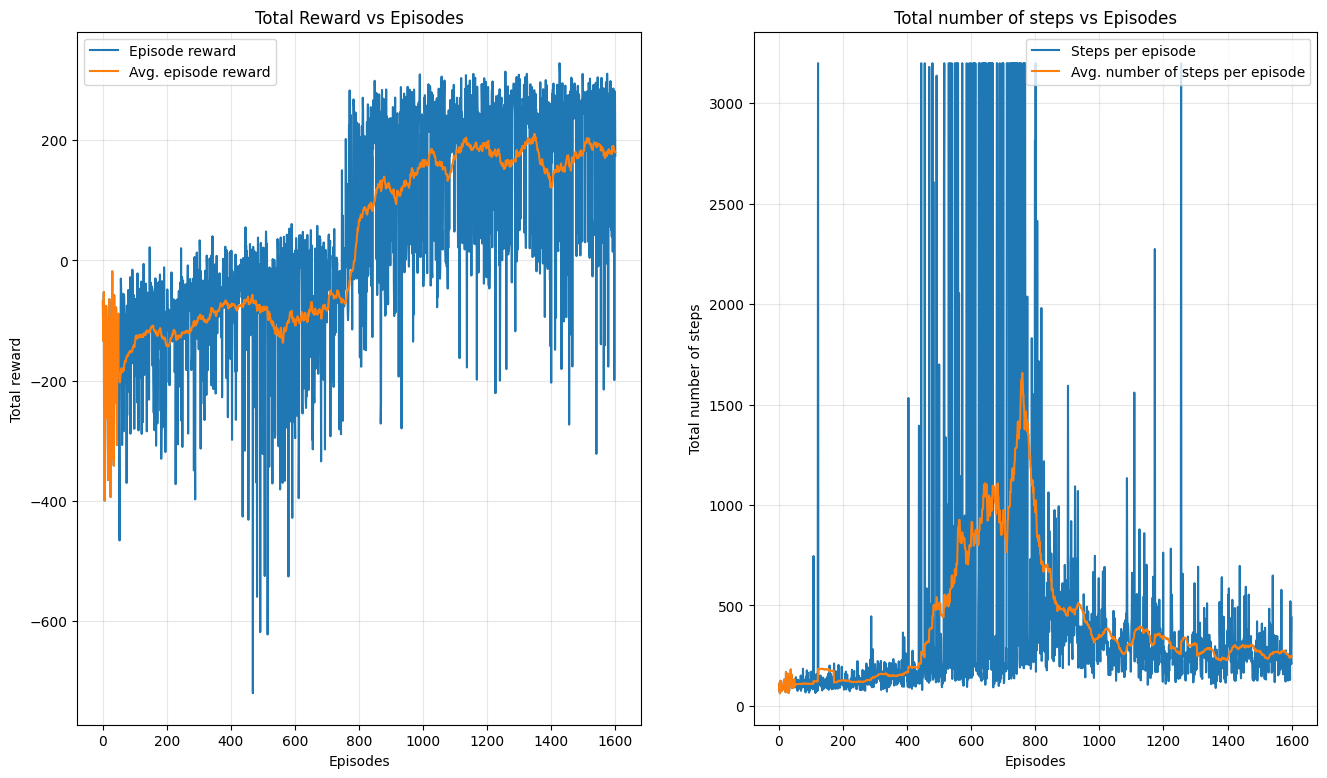

In [3]:
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    done = False
    state, _ = env.reset()
    total_episode_reward = 0.
    experience_replay_buffer = []
    t = 0
    #while not done:
    for _ in range(3200):
        if done: break
        action = network_actor.act(state).ravel()
        next_state, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

        # train
        experience_replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        t += 1
    
    train_network(network_actor, network_critic)

    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    env.close()

    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

while len(episode_reward_list) < N_episodes:
    episode_reward_list.append(episode_reward_list[-1])
    episode_number_of_steps.append(episode_number_of_steps[-1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

In [4]:
torch.save(network_actor, "neural-network-3-actor.pth")
torch.save(network_critic, "neural-network-3-critic.pth")